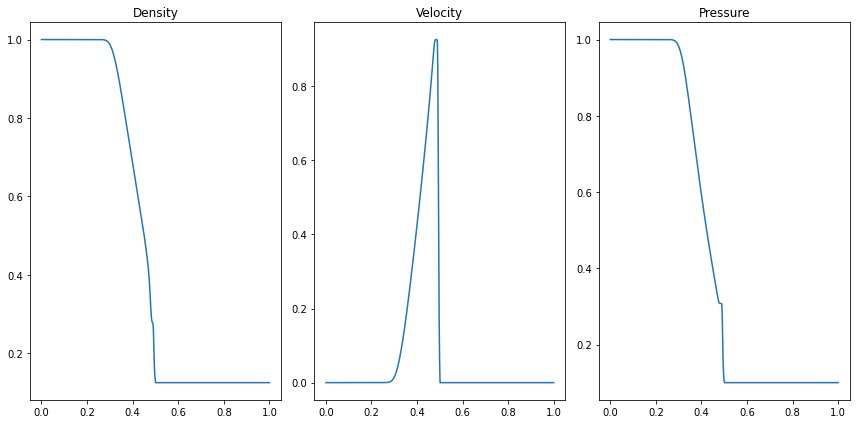

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
gamma = 1.4  # Adiabatic index for ideal gas

# Initial conditions: (rho, u, p) on the left and right
rho_L, u_L, p_L = 1.0, 0.0, 1.0
rho_R, u_R, p_R = 0.125, 0.0, 0.1

# Grid and time parameters
nx = 500 # Number of grid points
x = np.linspace(0, 1, nx)
dx = x[1] - x[0]
dt = 0.0001  # Time step
t_final = 0.15  # Final time

# Initialize primitive variables
rho = np.zeros(nx)
u = np.zeros(nx)
p = np.zeros(nx)

# Set initial conditions
rho[: nx // 2] = rho_L
u[: nx // 2] = u_L
p[: nx // 2] = p_L

rho[nx // 2 :] = rho_R
u[nx // 2 :] = u_R
p[nx // 2 :] = p_R

# Convert to conservative variables
E = p / (gamma - 1) + 0.5 * rho * u**2  # Energy density
U = np.array([rho, rho * u, E])  # [density, momentum, energy]

def flux(U):
    """Compute the flux for given conservative variables."""
    rho = U[0]
    u = U[1] / rho
    E = U[2]
    p = (gamma - 1) * (E - 0.5 * rho * u**2)

    F = np.zeros_like(U)
    F[0] = rho * u
    F[1] = rho * u**2 + p
    F[2] = u * (E + p)
    return F

def hll_flux(UL, UR):
    """Compute the HLL flux between two states UL and UR."""
    # Compute primitive variables
    rho_L, u_L, p_L = UL[0], UL[1] / UL[0], (gamma - 1) * (UL[2] - 0.5 * UL[1]**2 / UL[0])
    rho_R, u_R, p_R = UR[0], UR[1] / UR[0], (gamma - 1) * (UR[2] - 0.5 * UR[1]**2 / UR[0])

    # Wave speeds
    c_L = np.sqrt(gamma * p_L / rho_L)
    c_R = np.sqrt(gamma * p_R / rho_R)
    S_L = min(u_L - c_L, u_R - c_R)
    S_R = max(u_L + c_L, u_R + c_R)

    # Compute fluxes
    FL = flux(UL)
    FR = flux(UR)

    # HLL flux
    if S_L >= 0:
        return FL
    elif S_R <= 0:
        return FR
    else:
        return (S_R * FL - S_L * FR + S_L * S_R * (UR - UL)) / (S_R - S_L)

# Time integration loop
t = 0.0
while t < t_final:
    U_new = U.copy()

    # Compute fluxes at cell interfaces
    for i in range(1, nx):
        F = hll_flux(U[:, i - 1], U[:, i])
        U_new[:, i - 1] -= dt / dx * (F - flux(U[:, i - 1]))

    U = U_new
    t += dt


# Extract the final primitive variables
rho = U[0]
u = U[1] / rho
E = U[2]
p = (gamma - 1) * (E - 0.5 * rho * u**2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(x, rho)
plt.title("Density")

plt.subplot(132)
plt.plot(x, u)
plt.title("Velocity")

plt.subplot(133)
plt.plot(x, p)
plt.title("Pressure")

plt.tight_layout()
plt.show()



In [3]:
print(U)

[[0.93819459 0.76225628 0.125      0.125      0.125     ]
 [0.05529385 0.17855756 0.         0.         0.        ]
 [2.32574662 1.91079929 0.25       0.25       0.25      ]]
